## 安装方式(release的最新版本)： 
安装vnpy_fxdayu:

https://github.com/xingetouzi/vnpy_fxdayu/tree/release-1.1.13.dev1811227

## 配置引擎参数

In [10]:
import pandas as pd
import warnings
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import talib as ta
from talib import abstract

In [11]:
from vnpy.trader.app.ctaStrategy import BacktestingEngine

# 创建回测引擎对象
engine = BacktestingEngine()

# 设置回测使用的数据
engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
engine.setDatabase('VnTrader_1Min_Db')  # 设置使用的历史数据库
engine.setStartDate('20180601 12:00',initHours=200) # 设置回测用的数据起始日期
engine.setEndDate('20181123 12:00') # 设置回测用的数据终止日期

# 配置回测引擎参数
engine.setSlippage(0.002)    # 设置滑点
engine.setRate(5/10000)   # 设置手续费千1
engine.setCapital(1000000)  # 设置回测本金

In [14]:
from vnpy.trader.app.ctaStrategy import BacktestingEngine
import pandas as pd

def runBacktesting(strategyClass, settingDict,
                   startDate, endDate, slippage, rate):
    engine = BacktestingEngine()
    engine.setBacktestingMode(engine.BAR_MODE)  # 设置引擎的回测模式为K线
    engine.setDatabase('VnTrader_1Min_Db')    # 设置使用的历史数据库
    engine.setStartDate(startDate, initHours=200)   # 设置回测用的数据起始日期
    engine.setEndDate(endDate)     # 设置回测用的数据结束日期
    engine.setSlippage(slippage)    # 设置滑点
    engine.setRate(rate)             # 设置手续费万0.3
    engine.initStrategy(strategyClass, settingDict)
    engine.setCapital(100000)     # 设置回测本金
    engine.runBacktesting()
    #显示逐日回测结果
    engine.showDailyResult()
    #显示逐笔回测结果
    engine.showBacktestingResult()
    # 计算回测结果
    df = engine.calculateDailyResult()
    return df

## 策略编写与参数设置

参数与变量的区别: 参数用来传递并且可以优化，变量是随着过程的赋值改变的

## CtaTemplate 继承的属性与方法
1. self.symbolList: 支持多品种以列表格式输入引擎
2. self.posDict: 可记录多个品种的多空持仓的字典
3. self.cancelAll(): 取消所有订单
4. self.getArrayManager(symbol, freq): 数组管理器

In [80]:
from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta

########################################################################
# 策略继承CtaTemplate
class Strategy(CtaTemplate):
    className = 'MultiSignal'
    author = 'LuYiming'
    
   # 参数设置
    VWAPPeriod = 70
    BBandPeriod = 20
    roc_period = 20
    roc_ma1_period = 5;roc_ma2_period = 25
    volume_ma1_period = 5;volume_ma2_period = 25
    rsiPeriod = 10; rsiEntry = 12
    cciPeriod = 10; cciThrehold = 10
    trailingPct = 0.04
    lot = 1
    
    # 策略变量
    transactionPrice = {} # 记录成交价格
    RSI = {};CCI = {};ROC_MA = {};VWAP = {}
    
    
    # 参数列表
    paramList = ['roc_period','roc_ma1_period','roc_ma2_period','trailingPct',
                'cciPeriod', 'cciThrehold',
                'trailingPct','VWAPPeriod']    
    
    # 变量列表
    varList = ['transactionPrice','intraTradeHighDict', 'intraTradeLowDict',
              'CCI', 'VWAP', 'ROC_MA']  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        # 首先找到策略的父类（就是类CtaTemplate），然后把DoubleMaStrategy的对象转换为类CtaTemplate的对象
        super().__init__(ctaEngine, setting)
      
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList}
        self.intraTradeHighDict = {s:0 for s in self.symbolList}
        self.intraTradeLowDict = {s:999999 for s in self.symbolList}
        self.RSI = {s:0 for s in self.symbolList}
        self.VWAP = {s:0 for s in self.symbolList}
        self.ROC_MA = {s:0 for s in self.symbolList}
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
        
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送"""
        symbol = bar.vtSymbol
        
        # 洗价器（止盈止损）
        if self.posDict[symbol+'_LONG'] == 0 and self.posDict[symbol+'_SHORT'] == 0:
            self.intraTradeHighDict[symbol] = 0
            self.intraTradeLowDict[symbol] = 999999

        # 持有多头仓位
        elif self.posDict[symbol+'_LONG'] >0:
            self.intraTradeHighDict[symbol] = max(self.intraTradeHighDict[symbol], bar.high)
            self.longStop = self.intraTradeHighDict[symbol]*(1-self.trailingPct)
            if bar.close<=self.longStop:
                self.cancelAll()
                self.sell(symbol, bar.close*0.9, self.posDict[symbol+'_LONG'])

#         # 持有空头仓位
        elif self.posDict[symbol+'_SHORT'] >0:
            self.intraTradeLowDict[symbol] = min(self.intraTradeLowDict[symbol], bar.low)
            self.shortStop = self.intraTradeLowDict[symbol]*(1+self.trailingPct)
            if bar.close>=self.shortStop:
                self.cancelAll()
                self.cover(symbol, bar.close*1.1, self.posDict[symbol+'_SHORT'])
        self.putEvent()
        
    #----------------------------------------------------------------------
    def on60minBar(self, bar):
        """收到60分钟Bar推送"""
        symbol = bar.vtSymbol
        
        am60 = self.getArrayManager(symbol, "60m") # 获取历史数组
        
        if not am60.inited:
            return
        
        # 计算策略需要的信号-------------------------------------------------
#         up, mid, low = ta.BBANDS(am60.close, self.BBandPeriod)
#         sigma = (up -  mid) / (2 *  mid)
#         VWAP = ta.SUM(am60.close*am60.volume, self.VWAPPeriod) / ta.SUM(am60.volume, self.VWAPPeriod)
        
        ROC = ta.ROC(am60.close, self.roc_period)
        
        roc_ma1 = ta.MA(ROC, self.roc_ma1_period)
        roc_ma2 = ta.MA(ROC, self.roc_ma2_period)
        
        # 现象条件
        breakUp_roc = (roc_ma1[-1] > roc_ma2[-1]) and (roc_ma1[-2] <= roc_ma2[-2])
        breakDn_roc = (roc_ma1[-1] < roc_ma2[-1]) and (roc_ma1[-2] >= roc_ma2[-2])
        
        # 进出场条件
        if breakUp_roc and (self.posDict[symbol + "_LONG"]==0):
            if self.posDict[symbol + "_SHORT"] == 0:
                self.buy(symbol, bar.close * 1.01, self.lot)
            elif self.posDict[symbol + "_SHORT"] > 0:
                self.cover(symbol, bar.close * 1.01, self.posDict[symbol + "_SHORT"])
                self.buy(symbol, bar.close * 1.01, self.lot)
        elif breakDn_roc and (self.posDict[symbol + "_SHORT"]==0):
            if self.posDict[symbol + "_LONG"] == 0:
                self.short(symbol, bar.close * 0.9, self.lot)
            elif self.posDict[symbol + "_LONG"] > 0:
                self.sell(symbol, bar.close * 0.98, self.posDict[symbol + "_LONG"])
                self.short(symbol, bar.close *0.98, self.lot)
        
        # 发出状态更新事件
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60min_bar函数functools.partial(<function Strategy.on60minBar at 0x0000027982DB7D90>, <__main__.Strategy object at 0x00000279800E3D30>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function Strategy.onBar at 0x0000027982DB7B70>, <__main__.Strategy object at 0x00000279800E3D30>)
2018-12-09 13:11:03.269090	开始回测
2018-12-09 13:11:03.269090	策略初始化
2018-12-09 13:11:03.272078	载入历史数据。数据范围:[20180524 04:00,20180601 12:00)
2018-12-09 13:11:03.964243	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-09 13:11:03.968217	载入完成，数据量：12000
2018-12-09 13:11:03.968217	策略初始化完成
2018-12-09 13:11:03.968217	策略启动完成
2018-12-09 13:11:03.968217	开始回放回测数据,回测范围:[20180601 12:00,20181121 12:00)
2018-12-09 13:11:03.996144	载入历史数据。数据范围:[20180601 12:00,20181121 12:00)
2018-12-09 13:11:13.863756	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-09 13:11:13.931572	载入完成，数据量：247328
2018-12-09 13:11:13.933568	当前回放数据:[20180601 12

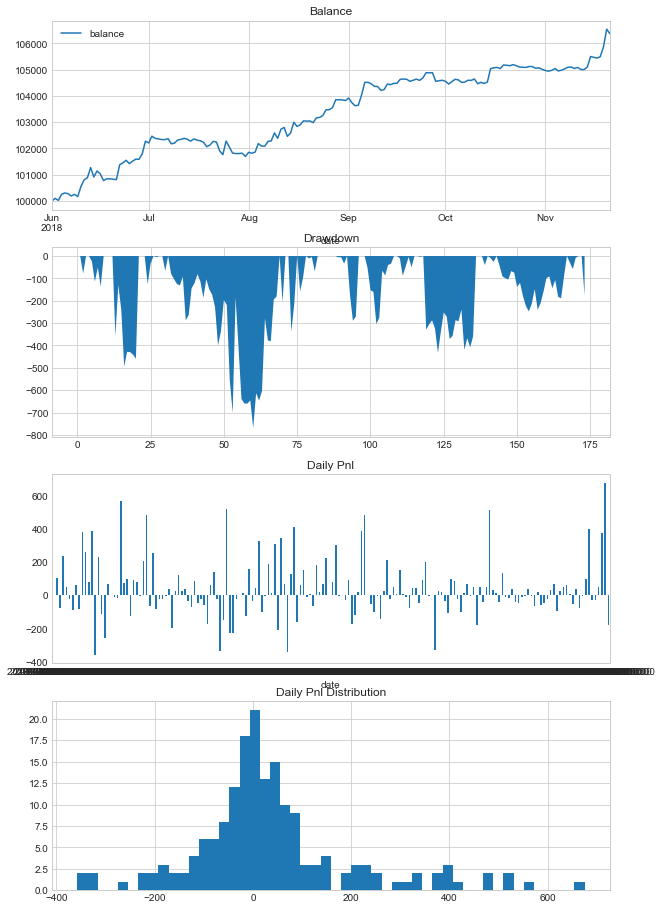

2018-12-09 13:11:34.085677	计算回测结果
2018-12-09 13:11:34.125571	------------------------------
2018-12-09 13:11:34.125571	第一笔交易：	2018-06-03 11:00:00
2018-12-09 13:11:34.126567	最后一笔交易：	2018-11-21 01:19:00
2018-12-09 13:11:34.126567	总交易次数：	213
2018-12-09 13:11:34.127565	总盈亏：	6,364.3
2018-12-09 13:11:34.127565	最大回撤: 	-878.76
2018-12-09 13:11:34.127565	平均每笔盈利：	29.88
2018-12-09 13:11:34.127565	平均每笔滑点：	0.0
2018-12-09 13:11:34.127565	平均每笔佣金：	6.7
2018-12-09 13:11:34.127565	胜率		40.38%
2018-12-09 13:11:34.127565	盈利交易平均值	158.44
2018-12-09 13:11:34.127565	亏损交易平均值	-57.18
2018-12-09 13:11:34.127565	盈亏比：	2.77


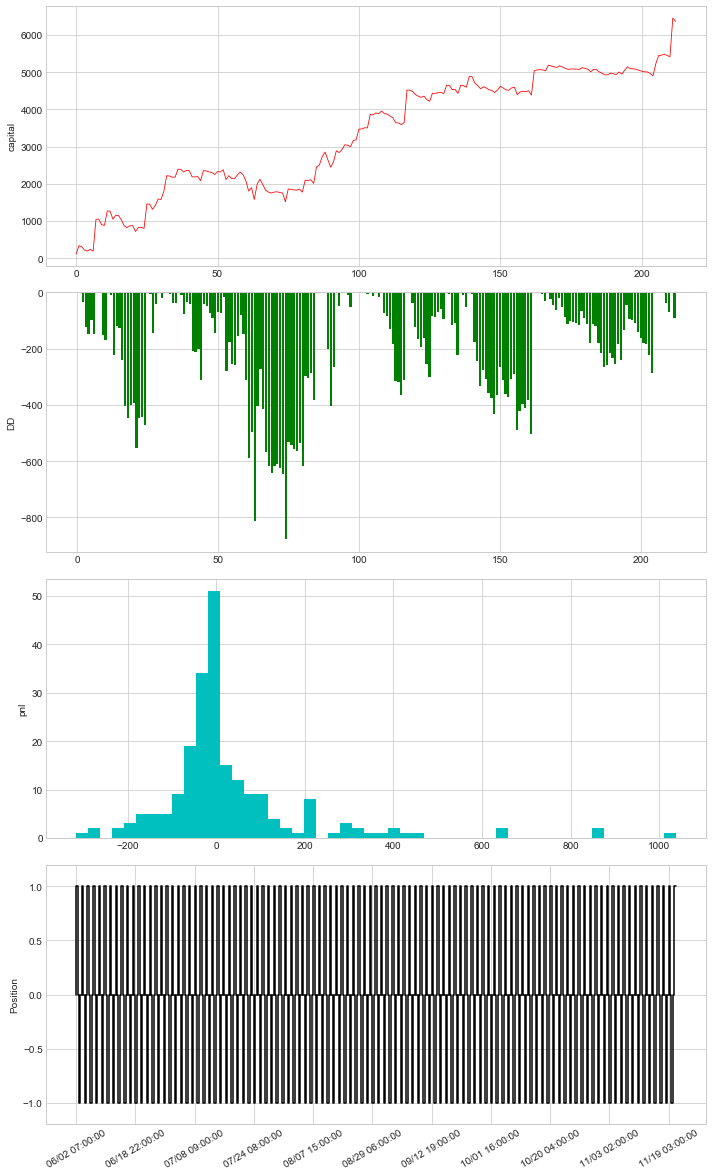

2018-12-09 13:11:34.974302	计算按日统计结果


,netPnl,slippage,commission,turnover,tradeCount,tradingPnl,positionPnl,totalPnl
date,,,,,,,,
2018-06-01,0.000000,0.000,0.000000,0.00,0,0.00,0.00,0.00
2018-06-02,101.419040,0.002,3.758960,7517.92,1,105.18,0.00,105.18
2018-06-03,-77.915420,0.004,7.641420,15282.84,2,-177.18,106.91,-70.27
2018-06-04,233.020000,0.000,0.000000,0.00,0,0.00,233.02,233.02
2018-06-05,48.698570,0.006,11.105430,22210.86,3,139.91,-80.10,59.81
2018-06-06,-24.326995,0.002,3.814995,7629.99,1,-20.51,0.00,-20.51
2018-06-07,-90.586400,0.004,7.712400,15424.80,2,-41.94,-40.93,-82.87
2018-06-08,63.680840,0.004,7.695160,15390.32,2,135.30,-63.92,71.38
2018-06-09,-84.989630,0.008,15.231630,30463.26,4,-87.26,17.51,-69.75


In [88]:
# 在引擎中创建策略对象
parameterDict = {'symbolList':['BTCUSDT:binance']} # 策略参数配置
# engine.initStrategy(Strategy, parameterDict)    # 创建策略对象
# engine.runBacktesting()
runBacktesting(Strategy, parameterDict, '20180601 12:00', '20181121 12:00', 0.002, 5/10000)

In [9]:
from vnpy.trader.app.ctaStrategy.ctaBacktesting  import OptimizationSetting
# 优化配置
setting = OptimizationSetting()                # 新建一个优化任务设置对象
setting.setOptimizeTarget('sharpeRatio')       # 设置优化排序的目标是夏普

# setting.addParameter('roc_period', 10, 30, 5)
setting.addParameter('roc_ma1_period', 5, 15, 5)    # 增加第一个优化参数，起始30，结束50，步进10
setting.addParameter('roc_ma2_period', 25, 40, 5)    # 增加第二个优化参数，起始60，结束30，步进10
# setting.addParameter('signalMaPeriod', 10, 20, 5)    # 增加第二个优化参数，起始10，结束30，步进5

setting.addParameter('symbolList', ['BTCUSDT:binance']) 

import time
start = time.time()
# 执行单线程优化
resultList = engine.runOptimization(Strategy, setting)
# 执行多进程优化一般会改写成py文件然后用多线程运行，提高优化速度。
# resultList = engine.runParallelOptimization(Strategy, setting)
# print('耗时：%s' %(time.time()-start))

2018-12-09 00:57:06.368638	------------------------------
2018-12-09 00:57:06.369639	setting: {'roc_ma1_period': 5, 'roc_ma2_period': 25, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function Strategy.on60MinBar at 0x0000027989CD6488>, <__main__.Strategy object at 0x0000027989CBCCF8>)
2018-12-09 00:57:06.372628	开始回测
2018-12-09 00:57:06.372628	策略初始化
2018-12-09 00:57:06.377614	载入历史数据。数据范围:[20180524 04:00,20180601 12:00)
2018-12-09 00:57:06.962051	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-09 00:57:06.965043	载入完成，数据量：12000
2018-12-09 00:57:06.966041	策略初始化完成
2018-12-09 00:57:06.967037	策略启动完成
2018-12-09 00:57:06.967037	开始回放回测数据,回测范围:[20180601 12:00,20181123 12:00)
2018-12-09 00:57:06.989009	载入历史数据。数据范围:[20180601 12:00,20181123 12:00)
2018-12-09 00:57:18.309705	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-09 00:57:18.420408	载入完成，数据量：250208
2018-12-09 00:57:18.421417	当前回

Traceback (most recent call last):
  File "G:\Anaconda\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "G:\Anaconda\lib\site-packages\pandas\core\generic.py", line 2970, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7491.22, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 962.8287040000002, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528090000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的60mK线准备就绪,当前K线时间为20180601120000
2018-12-09 00:57:40.342784	数据回放结束ss: 100%    
2018-12-09 00:57:40.343781	计算按日统计结果
2018-12-09 00:57:40.547238	------------------------------
2018-12-09 00:57:40.547238	setting: {'roc_ma1_period': 5, 'roc_ma2_period': 30, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种B

Traceback (most recent call last):
  File "G:\Anaconda\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "G:\Anaconda\lib\site-packages\pandas\core\generic.py", line 2970, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7491.22, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 962.8287040000002, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528090000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的60mK线准备就绪,当前K线时间为20180601120000
2018-12-09 00:58:23.345881	数据回放结束ss: 100%    
2018-12-09 00:58:23.345881	计算按日统计结果
2018-12-09 00:58:23.528392	------------------------------
2018-12-09 00:58:23.529390	setting: {'roc_ma1_period': 5, 'roc_ma2_period': 35, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种B

Traceback (most recent call last):
  File "G:\Anaconda\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "G:\Anaconda\lib\site-packages\pandas\core\generic.py", line 2970, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7491.22, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 962.8287040000002, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528090000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的60mK线准备就绪,当前K线时间为20180601120000
2018-12-09 00:58:55.443079	数据回放结束ss: 100%    
2018-12-09 00:58:55.443079	计算按日统计结果
2018-12-09 00:58:55.589657	------------------------------
2018-12-09 00:58:55.589657	setting: {'roc_ma1_period': 5, 'roc_ma2_period': 40, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种B

Traceback (most recent call last):
  File "G:\Anaconda\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "G:\Anaconda\lib\site-packages\pandas\core\generic.py", line 2970, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7491.22, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 962.8287040000002, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528090000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的60mK线准备就绪,当前K线时间为20180601120000
2018-12-09 00:59:27.488386	数据回放结束ss: 100%    
2018-12-09 00:59:27.490381	计算按日统计结果
2018-12-09 00:59:27.675884	------------------------------
2018-12-09 00:59:27.677880	setting: {'roc_ma1_period': 10, 'roc_ma2_period': 25, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种

Traceback (most recent call last):
  File "G:\Anaconda\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "G:\Anaconda\lib\site-packages\pandas\core\generic.py", line 2970, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7491.22, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 962.8287040000002, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528090000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的60mK线准备就绪,当前K线时间为20180601120000
2018-12-09 00:59:58.451584	数据回放结束ss: 100%    
2018-12-09 00:59:58.452582	计算按日统计结果
2018-12-09 00:59:58.692937	------------------------------
2018-12-09 00:59:58.693936	setting: {'roc_ma1_period': 10, 'roc_ma2_period': 30, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种

Traceback (most recent call last):
  File "G:\Anaconda\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "G:\Anaconda\lib\site-packages\pandas\core\generic.py", line 2970, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7491.22, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 962.8287040000002, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528090000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的60mK线准备就绪,当前K线时间为20180601120000
2018-12-09 01:00:29.499557	数据回放结束ss: 100%    
2018-12-09 01:00:29.499557	计算按日统计结果
2018-12-09 01:00:29.640178	------------------------------
2018-12-09 01:00:29.640178	setting: {'roc_ma1_period': 10, 'roc_ma2_period': 35, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种

Traceback (most recent call last):
  File "G:\Anaconda\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "G:\Anaconda\lib\site-packages\pandas\core\generic.py", line 2970, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7491.22, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 962.8287040000002, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528090000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的60mK线准备就绪,当前K线时间为20180601120000
2018-12-09 01:01:00.980370	数据回放结束ss: 100%    
2018-12-09 01:01:00.980370	计算按日统计结果
2018-12-09 01:01:01.136950	------------------------------
2018-12-09 01:01:01.136950	setting: {'roc_ma1_period': 10, 'roc_ma2_period': 40, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种

Traceback (most recent call last):
  File "G:\Anaconda\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "G:\Anaconda\lib\site-packages\pandas\core\generic.py", line 2970, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7491.22, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 962.8287040000002, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528090000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的60mK线准备就绪,当前K线时间为20180601120000
2018-12-09 01:01:35.900985	数据回放结束ss: 100%    
2018-12-09 01:01:35.900985	计算按日统计结果
2018-12-09 01:01:36.070531	------------------------------
2018-12-09 01:01:36.070531	setting: {'roc_ma1_period': 15, 'roc_ma2_period': 25, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种

Traceback (most recent call last):
  File "G:\Anaconda\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "G:\Anaconda\lib\site-packages\pandas\core\generic.py", line 2970, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7491.22, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 962.8287040000002, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528090000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的60mK线准备就绪,当前K线时间为20180601120000
2018-12-09 01:02:11.317276	数据回放结束ss: 100%    
2018-12-09 01:02:11.318274	计算按日统计结果
2018-12-09 01:02:11.504773	------------------------------
2018-12-09 01:02:11.505771	setting: {'roc_ma1_period': 15, 'roc_ma2_period': 30, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种

Traceback (most recent call last):
  File "G:\Anaconda\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "G:\Anaconda\lib\site-packages\pandas\core\generic.py", line 2970, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7491.22, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 962.8287040000002, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528090000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的60mK线准备就绪,当前K线时间为20180601120000
2018-12-09 01:02:45.948698	数据回放结束ss: 100%    
2018-12-09 01:02:45.948698	计算按日统计结果
2018-12-09 01:02:46.092281	------------------------------
2018-12-09 01:02:46.092281	setting: {'roc_ma1_period': 15, 'roc_ma2_period': 35, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种

Traceback (most recent call last):
  File "G:\Anaconda\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "G:\Anaconda\lib\site-packages\pandas\core\generic.py", line 2970, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7491.22, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 962.8287040000002, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528090000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的60mK线准备就绪,当前K线时间为20180601120000
2018-12-09 01:03:13.406240	数据回放结束ss: 100%    
2018-12-09 01:03:13.406240	计算按日统计结果
2018-12-09 01:03:13.555836	------------------------------
2018-12-09 01:03:13.556836	setting: {'roc_ma1_period': 15, 'roc_ma2_period': 40, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种

Traceback (most recent call last):
  File "G:\Anaconda\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "G:\Anaconda\lib\site-packages\pandas\core\generic.py", line 2970, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7491.22, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 962.8287040000002, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528090000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的60mK线准备就绪,当前K线时间为20180601120000
2018-12-09 01:03:40.881797	数据回放结束ss: 100%    
2018-12-09 01:03:40.881797	计算按日统计结果
2018-12-09 01:03:40.914675	------------------------------
2018-12-09 01:03:40.915675	优化结果：
2018-12-09 01:03:40.915675	参数：["{'roc_ma1_period': 5, 'roc_ma2_period': 25, 'symbolList': ['BTCUSDT:binance']}"]，目标：2.3859422188687955
2018-12-09 01:03:40.916669	参数：["